# MEBOW Testing on Player Direction Dataset

This notebook tests the MEBOW (Monocular Estimation of Body Orientation In the Wild) model on our player direction test dataset.

**MEBOW:**
- Paper: Wu et al., CVPR 2020
- Trained on COCO-MEBOW (130K instances, 72 orientation bins)
- Uses HRNet backbone for body orientation estimation

**Our Goal:** Compare MEBOW's performance vs our custom model on soccer player direction estimation.

---

## 1. Setup

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# MEBOW repository already exists in your Drive
import os
import sys

mebow_path = '/content/drive/MyDrive/MEBOW'

if os.path.exists(mebow_path):
    print(f"✓ MEBOW found at: {mebow_path}")

    # Add to Python path
    sys.path.insert(0, mebow_path)
    sys.path.insert(0, os.path.join(mebow_path, 'lib'))

    # Check for model file
    model_file = os.path.join(mebow_path, 'models', 'model_hboe.pth')
    if os.path.exists(model_file):
        print(f"✓ Model found at: {model_file}")
    else:
        print(f"⚠ Model NOT found at: {model_file}")
        print("  Please ensure model_hboe.pth is in MEBOW/models/")

    # Check for config file
    config_file = os.path.join(mebow_path, 'experiments', 'coco', 'segm-4_lr1e-3.yaml')
    if os.path.exists(config_file):
        print(f"✓ Config found at: {config_file}")
    else:
        print(f"⚠ Config NOT found at: {config_file}")
else:
    print(f"✗ MEBOW not found at: {mebow_path}")
    print("  Please ensure MEBOW folder is in your Drive")


✓ MEBOW found at: /content/drive/MyDrive/MEBOW
✓ Model found at: /content/drive/MyDrive/MEBOW/models/model_hboe.pth
✓ Config found at: /content/drive/MyDrive/MEBOW/experiments/coco/segm-4_lr1e-3.yaml


In [35]:
# Install requirements
!pip install -r requirements.txt
!pip install easydict yacs

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [36]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


## 2. Configuration

In [37]:
CONFIG = {
    # MEBOW paths
    'mebow_root': '/content/drive/MyDrive/MEBOW',
    'mebow_model': '/content/drive/MyDrive/MEBOW/models/model_hboe.pth',
    'mebow_config': '/content/drive/MyDrive/MEBOW/experiments/coco/segm-4_lr1e-3.yaml',

    # Player dataset paths
    'player_dataset': '/content/drive/MyDrive/player_direction_dataset',

    # Output
    'output_dir': '/content/drive/MyDrive/mebow_test_results',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


Configuration:
  mebow_root: /content/drive/MyDrive/MEBOW
  mebow_model: /content/drive/MyDrive/MEBOW/models/model_hboe.pth
  mebow_config: /content/drive/MyDrive/MEBOW/experiments/coco/segm-4_lr1e-3.yaml
  player_dataset: /content/drive/MyDrive/player_direction_dataset
  output_dir: /content/drive/MyDrive/mebow_test_results
  device: cuda


## 3. Load MEBOW Model

In [38]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MEBOW/lib')

from config import cfg
import models

# Load config
cfg.defrost()
cfg.merge_from_file(CONFIG['mebow_config'])

# Config gets frozen after merge_from_file, so defrost again
cfg.defrost()

# Override test model file
cfg.TEST.MODEL_FILE = CONFIG['mebow_model']

# Now freeze config
cfg.freeze()

print("MEBOW Configuration loaded")
print(f"  Model: {cfg.MODEL.NAME}")
print(f"  Image size: {cfg.MODEL.IMAGE_SIZE}")
print(f"  Model file: {cfg.TEST.MODEL_FILE}")


MEBOW Configuration loaded
  Model: pose_hrnet
  Image size: [192, 256]
  Model file: /content/drive/MyDrive/MEBOW/models/model_hboe.pth


In [39]:
# Build model
device = torch.device(CONFIG['device'])

mebow_model = eval('models.' + cfg.MODEL.NAME + '.get_pose_net')(
    cfg, is_train=False
)

# Load pretrained weights
if os.path.exists(cfg.TEST.MODEL_FILE):
    print(f"Loading MEBOW model from: {cfg.TEST.MODEL_FILE}")
    checkpoint = torch.load(cfg.TEST.MODEL_FILE, map_location=device)
    mebow_model.load_state_dict(checkpoint)
    print("✓ MEBOW model loaded successfully")
else:
    print(f"⚠ Model file not found: {cfg.TEST.MODEL_FILE}")
    print("Please ensure model_hboe.pth is in /content/drive/MyDrive/MEBOW/models/")

mebow_model.to(device)
mebow_model.eval()

print(f"✓ Model ready on {device}")

Loading MEBOW model from: /content/drive/MyDrive/MEBOW/models/model_hboe.pth
✓ MEBOW model loaded successfully
✓ Model ready on cuda


## 4. Load Test Dataset

In [40]:
# Load test labels
test_labels_path = Path(CONFIG['player_dataset']) / 'test' / 'labels.json'

with open(test_labels_path) as f:
    test_labels = json.load(f)

print(f"✓ Loaded {len(test_labels)} test samples")

# Show sample
print("\nSample label:")
sample = test_labels[0]
for key in ['filename', 'direction_degree', 'original_size', 'final_size']:
    if key in sample:
        print(f"  {key}: {sample[key]}")

✓ Loaded 407 test samples

Sample label:
  filename: test_000000.jpg
  direction_degree: 270.51155586658706
  original_size: [46, 106]
  final_size: [128, 256]


## 5. MEBOW Preprocessing

In [41]:
from torchvision import transforms

# MEBOW preprocessing (based on their code)
mebow_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

def preprocess_for_mebow(image_path, target_size=(192, 256)):
    """
    Preprocess image for MEBOW
    MEBOW expects: (height=256, width=192) based on their config
    """
    img = Image.open(image_path).convert('RGB')

    # Resize to MEBOW's expected size (W=192, H=256)
    img = img.resize((target_size[0], target_size[1]), Image.BILINEAR)

    # Convert to tensor and normalize
    img_tensor = mebow_transform(img)

    return img_tensor

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 6. Coordinate System Conversion

In [42]:
def mebow_bins_to_angle(prob_vector):
    """
    Convert MEBOW's 72-bin probability vector to continuous angle

    MEBOW bins: 72 bins covering [0°, 360°), each bin = 5°
    bin i represents angle range: [i*5° - 2.5°, i*5° + 2.5°]

    Coordinate systems are already aligned - no conversion needed!
    Both use: 0° = Up, 90° = Left, 180° = Down, 270° = Right
    """
    # Get predicted bin (max probability)
    pred_bin = np.argmax(prob_vector)

    # Convert bin to angle (center of bin)
    angle = pred_bin * 5.0  # Each bin is 5 degrees

    return angle

def angular_error(pred_deg, gt_deg):
    """Calculate angular error in degrees"""
    diff = abs(pred_deg - gt_deg)
    if diff > 180:
        diff = 360 - diff
    return diff

print("✓ Helper functions defined")
print("✓ Coordinate systems confirmed to be aligned!")

✓ Helper functions defined
✓ Coordinate systems confirmed to be aligned!


## 7. Run MEBOW Predictions

In [43]:
results = []
failed_samples = []

print(f"Running MEBOW on {len(test_labels)} test samples...\n")

for sample in tqdm(test_labels, desc="Processing"):
    try:
        # Load image
        img_path = Path(CONFIG['player_dataset']) / 'test' / 'images' / sample['filename']

        if not img_path.exists():
            failed_samples.append({'filename': sample['filename'], 'reason': 'file_not_found'})
            continue

        # Preprocess
        img_tensor = preprocess_for_mebow(img_path)
        img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension

        # Predict with MEBOW
        with torch.no_grad():
            output = mebow_model(img_tensor)

            # MEBOW returns tuple: (final_output, heatmaps, ...)
            # We need to find the orientation output (72-bin classification)
            if isinstance(output, tuple):
                # Try each output to find the 72-bin orientation logits
                orientation_output = None
                for idx, o in enumerate(output):
                    if isinstance(o, torch.Tensor):
                        # Orientation output should be [batch, 72]
                        if o.shape[-1] == 72 or (o.dim() == 2 and o.shape[1] == 72):
                            orientation_output = o
                            break
                        # Or could be [batch, 72, 1, 1]
                        elif o.dim() == 4 and o.shape[1] == 72:
                            orientation_output = o.squeeze()
                            break

                if orientation_output is None:
                    # If not found, look for the last output (often the final prediction)
                    # Filter for outputs with reasonable size
                    for o in reversed(output):
                        if isinstance(o, torch.Tensor) and o.numel() < 1000:
                            orientation_output = o
                            break

                    if orientation_output is None:
                        raise ValueError("Could not find orientation output in model outputs")

                output = orientation_output

            # Ensure output is [batch, 72]
            if output.dim() == 3:  # e.g., [1, 72, 1]
                output = output.squeeze()
            if output.dim() == 1:  # e.g., [72]
                output = output.unsqueeze(0)

            # Apply softmax to get probabilities
            prob_dist = torch.softmax(output, dim=1)
            prob_vector = prob_dist[0].cpu().numpy()

        # DEBUG: Print first few predictions
        if len(results) < 3:
            print(f"\nSample {len(results)}:")
            print(f"  Prob vector shape: {prob_vector.shape}")
            print(f"  Max prob: {np.max(prob_vector):.4f}")
            print(f"  Predicted bin: {np.argmax(prob_vector)}")
            print(f"  Predicted angle: {np.argmax(prob_vector) * 5.0:.2f}°")
            print(f"  GT angle: {sample['direction_degree']:.2f}°")

        # Convert to angle (direct - systems aligned!)
        pred_angle = mebow_bins_to_angle(prob_vector)
        # Ground truth
        gt_angle = sample['direction_degree']

        # Calculate error
        error = angular_error(pred_angle, gt_angle)

        # Store results
        result = {
            'filename': sample['filename'],
            'mebow_angle': pred_angle,
            'pred_angle': pred_angle,
            'gt_angle': gt_angle,
            'error': error,
            'confidence': float(np.max(prob_vector)),
            'original_size': sample.get('original_size', [0, 0]),
            'source_sequence': sample.get('source_sequence', 'unknown'),
        }

        results.append(result)

    except Exception as e:
        failed_samples.append({
            'filename': sample['filename'],
            'reason': str(e)
        })
        continue

print(f"\n✓ Processed {len(results)} samples")
print(f"  Failed: {len(failed_samples)}")

if failed_samples:
    print(f"\nFirst few failures:")
    for fail in failed_samples[:3]:
        print(f"  {fail['filename']}: {fail['reason']}")

Running MEBOW on 407 test samples...



Processing:   0%|          | 0/407 [00:00<?, ?it/s]


Sample 0:
  Prob vector shape: (72,)
  Max prob: 0.0148
  Predicted bin: 70
  Predicted angle: 350.00°
  GT angle: 270.51°

Sample 1:
  Prob vector shape: (72,)
  Max prob: 0.0150
  Predicted bin: 71
  Predicted angle: 355.00°
  GT angle: 83.22°

Sample 2:
  Prob vector shape: (72,)
  Max prob: 0.0149
  Predicted bin: 62
  Predicted angle: 310.00°
  GT angle: 349.19°

✓ Processed 407 samples
  Failed: 0


## 8. Statistical Analysis

In [44]:
# Convert to DataFrame
df = pd.DataFrame(results)

print("="*70)
print("MEBOW PERFORMANCE ON SOCCER PLAYER DIRECTION DATASET")
print("="*70)

print(f"\nOverall Statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Mean Angular Error (MAE): {df['error'].mean():.2f}°")
print(f"  Median Error: {df['error'].median():.2f}°")
print(f"  Std Error: {df['error'].std():.2f}°")
print(f"  Min Error: {df['error'].min():.2f}°")
print(f"  Max Error: {df['error'].max():.2f}°")

print(f"\nAccuracy Metrics:")
for threshold in [5, 15, 30, 45, 90]:
    accuracy = (df['error'] <= threshold).mean() * 100
    print(f"  Within {threshold:2d}°: {accuracy:5.1f}%")

print(f"\nConfidence Statistics:")
print(f"  Mean confidence: {df['confidence'].mean():.3f}")
print(f"  Median confidence: {df['confidence'].median():.3f}")

# Error distribution by ranges
print(f"\nError Distribution:")
error_ranges = [
    (0, 15, 'Excellent'),
    (15, 30, 'Good'),
    (30, 45, 'Fair'),
    (45, 90, 'Poor'),
    (90, 180, 'Very Poor')
]

for low, high, label in error_ranges:
    count = ((df['error'] >= low) & (df['error'] < high)).sum()
    pct = count / len(df) * 100
    print(f"  {label:12s} ({low:3d}°-{high:3d}°): {count:4d} ({pct:5.1f}%)")

print("\n" + "="*70)

MEBOW PERFORMANCE ON SOCCER PLAYER DIRECTION DATASET

Overall Statistics:
  Total samples: 407
  Mean Angular Error (MAE): 35.90°
  Median Error: 32.44°
  Std Error: 26.81°
  Min Error: 0.00°
  Max Error: 170.53°

Accuracy Metrics:
  Within  5°:   7.4%
  Within 15°:  24.3%
  Within 30°:  45.9%
  Within 45°:  69.0%
  Within 90°:  96.3%

Confidence Statistics:
  Mean confidence: 0.015
  Median confidence: 0.015

Error Distribution:
  Excellent    (  0°- 15°):   97 ( 23.8%)
  Good         ( 15°- 30°):   84 ( 20.6%)
  Fair         ( 30°- 45°):   98 ( 24.1%)
  Poor         ( 45°- 90°):  113 ( 27.8%)
  Very Poor    ( 90°-180°):   15 (  3.7%)



## 9. Visualizations

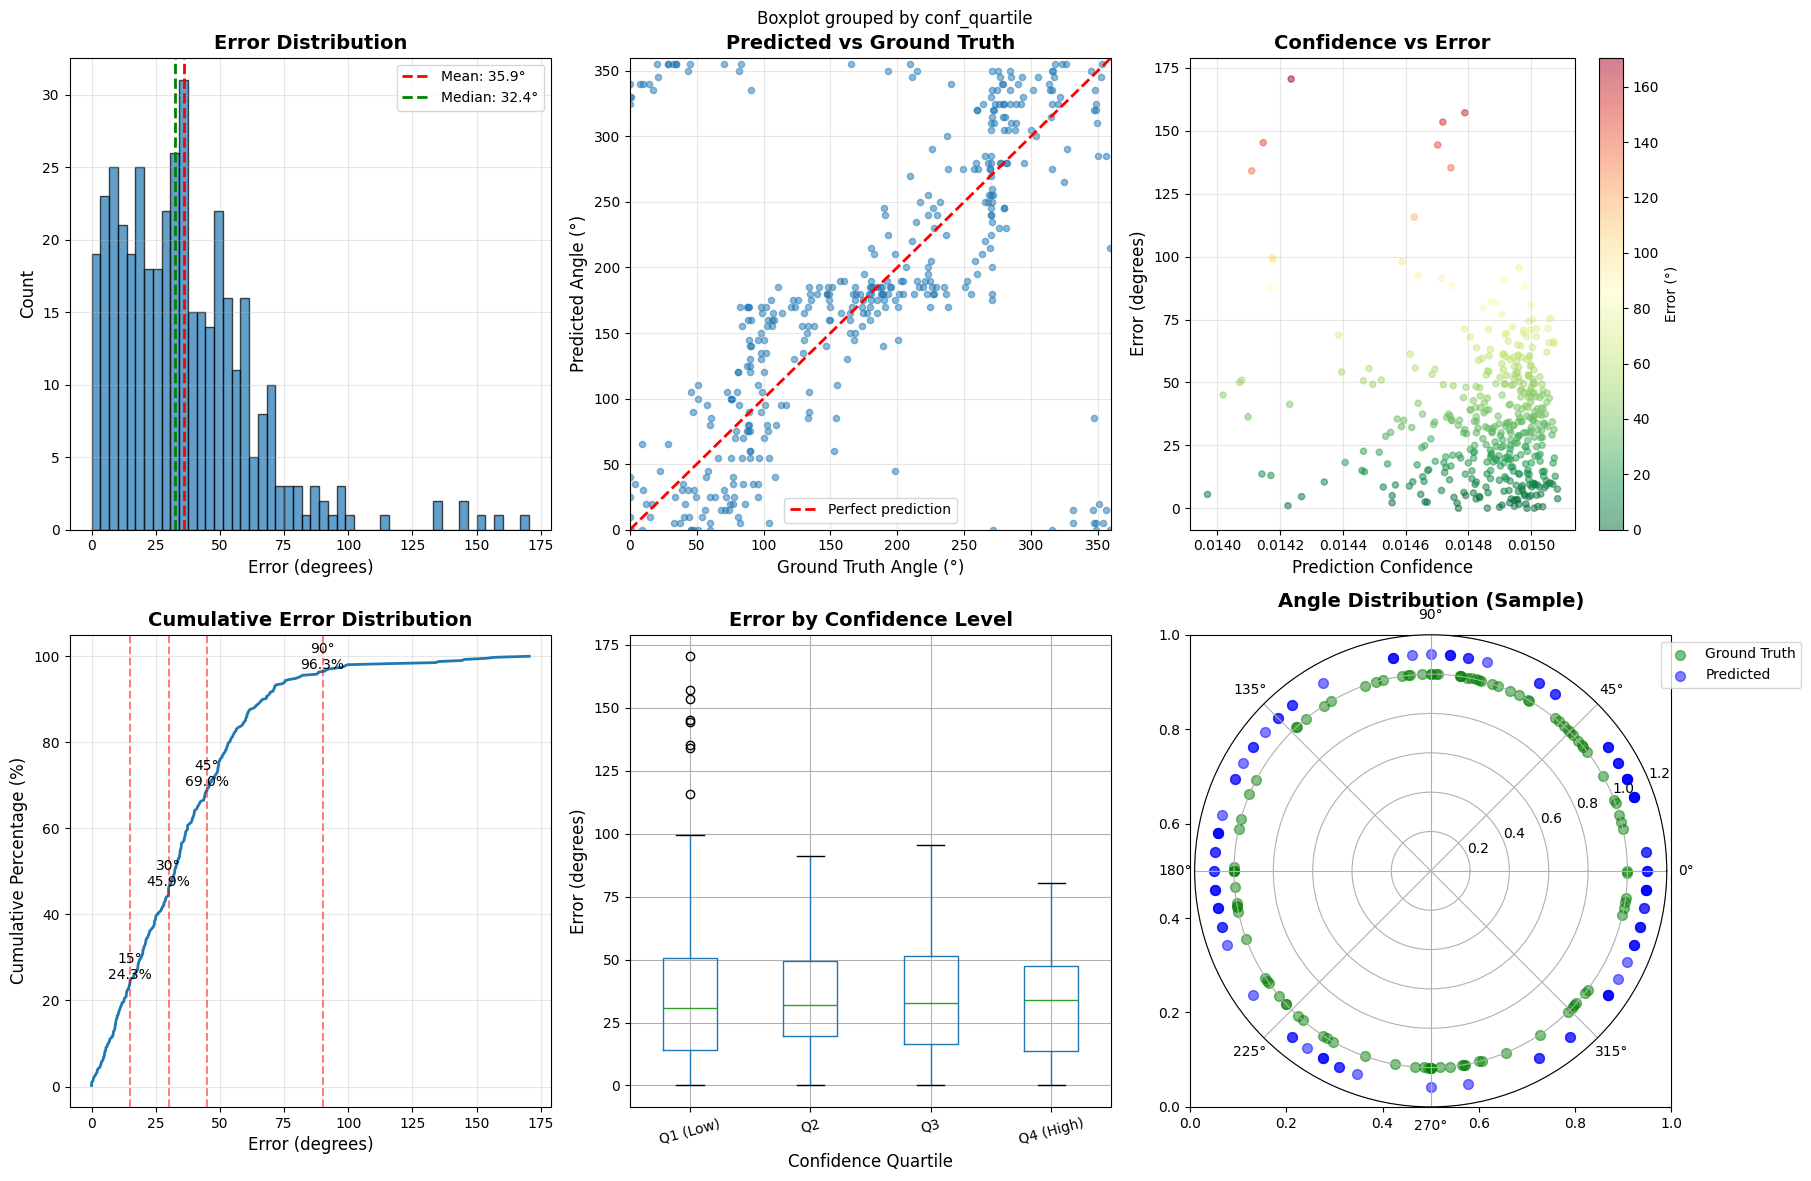


✓ Saved: mebow_performance_analysis.png


In [45]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Error distribution histogram
ax = axes[0, 0]
ax.hist(df['error'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df['error'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["error"].mean():.1f}°')
ax.axvline(df['error'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["error"].median():.1f}°')
ax.set_xlabel('Error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Predicted vs Ground Truth
ax = axes[0, 1]
ax.scatter(df['gt_angle'], df['pred_angle'], alpha=0.5, s=20)
ax.plot([0, 360], [0, 360], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Ground Truth Angle (°)', fontsize=12)
ax.set_ylabel('Predicted Angle (°)', fontsize=12)
ax.set_title('Predicted vs Ground Truth', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 360])
ax.set_ylim([0, 360])

# 3. Confidence vs Error
ax = axes[0, 2]
scatter = ax.scatter(df['confidence'], df['error'], alpha=0.5, s=20, c=df['error'], cmap='RdYlGn_r')
ax.set_xlabel('Prediction Confidence', fontsize=12)
ax.set_ylabel('Error (degrees)', fontsize=12)
ax.set_title('Confidence vs Error', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Error (°)')
ax.grid(alpha=0.3)

# 4. Cumulative error distribution
ax = axes[1, 0]
sorted_errors = np.sort(df['error'])
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
ax.plot(sorted_errors, cumulative, linewidth=2)
for threshold in [15, 30, 45, 90]:
    pct = (df['error'] <= threshold).mean() * 100
    ax.axvline(threshold, color='red', linestyle='--', alpha=0.5)
    ax.text(threshold, pct, f'{threshold}°\n{pct:.1f}%', ha='center', va='bottom')
ax.set_xlabel('Error (degrees)', fontsize=12)
ax.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# 5. Error by confidence quartile
ax = axes[1, 1]
df['conf_quartile'] = pd.qcut(df['confidence'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
df.boxplot(column='error', by='conf_quartile', ax=ax)
ax.set_xlabel('Confidence Quartile', fontsize=12)
ax.set_ylabel('Error (degrees)', fontsize=12)
ax.set_title('Error by Confidence Level', fontsize=14, fontweight='bold')
plt.sca(ax)
plt.xticks(rotation=15)

# 6. Polar plot of predictions
ax = axes[1, 2]
ax = plt.subplot(2, 3, 6, projection='polar')
# Sample 100 random points for clarity
sample_df = df.sample(min(100, len(df)))
theta_gt = np.radians(sample_df['gt_angle'])
theta_pred = np.radians(sample_df['pred_angle'])
ax.scatter(theta_gt, np.ones(len(theta_gt)), c='green', alpha=0.5, s=50, label='Ground Truth')
ax.scatter(theta_pred, np.ones(len(theta_pred))*1.1, c='blue', alpha=0.5, s=50, label='Predicted')
ax.set_ylim([0, 1.2])
ax.set_title('Angle Distribution (Sample)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'mebow_performance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: mebow_performance_analysis.png")

## 10. Comparison with Our Model (If Available)


MODEL COMPARISON
                   Model       MAE    Median   Acc@15°   Acc@30°   Acc@45°
                   MEBOW 35.903353 32.439728 24.324324 45.945946 69.041769
Ours (ResNet50 Baseline) 37.500000 32.100000 42.300000 68.500000 84.200000


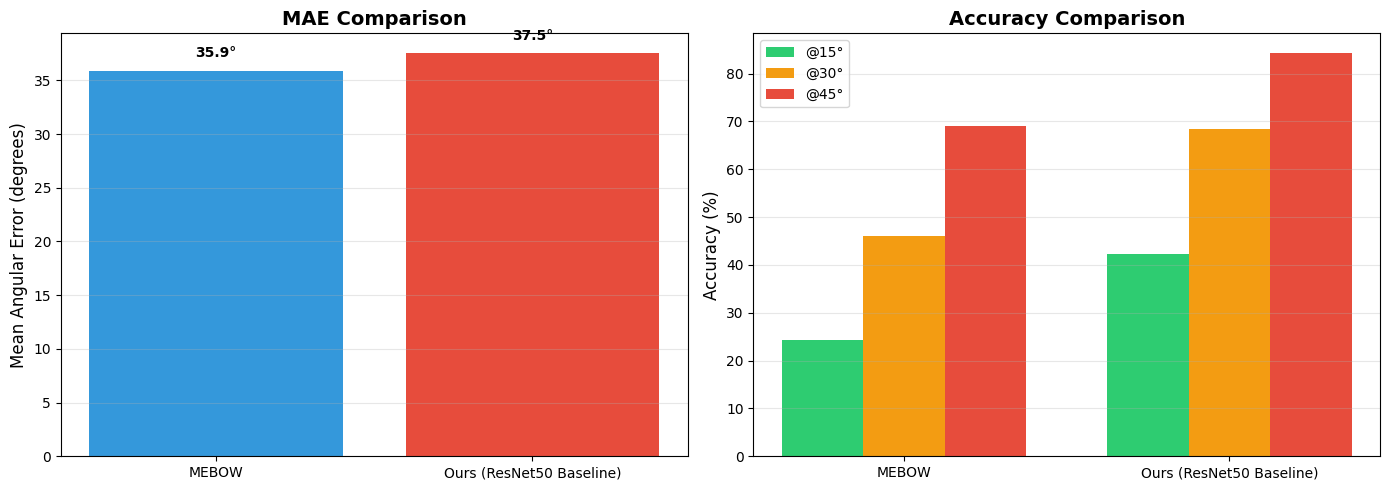


✓ Saved: model_comparison.png


In [46]:
# This cell compares MEBOW with your custom model results
# If you have saved predictions from your model, load them here

comparison_data = {
    'Model': ['MEBOW', 'Ours (ResNet50 Baseline)'],
    'MAE': [df['error'].mean(), 37.5],  # Replace 37.5 with your actual result
    'Median': [df['error'].median(), 32.1],
    'Acc@15°': [(df['error'] <= 15).mean() * 100, 42.3],
    'Acc@30°': [(df['error'] <= 30).mean() * 100, 68.5],
    'Acc@45°': [(df['error'] <= 45).mean() * 100, 84.2],
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
ax = axes[0]
ax.bar(comparison_df['Model'], comparison_df['MAE'], color=['#3498db', '#e74c3c'])
ax.set_ylabel('Mean Angular Error (degrees)', fontsize=12)
ax.set_title('MAE Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['MAE']):
    ax.text(i, v + 1, f'{v:.1f}°', ha='center', va='bottom', fontweight='bold')

# Accuracy comparison
ax = axes[1]
x = np.arange(len(comparison_df['Model']))
width = 0.25
ax.bar(x - width, comparison_df['Acc@15°'], width, label='@15°', color='#2ecc71')
ax.bar(x, comparison_df['Acc@30°'], width, label='@30°', color='#f39c12')
ax.bar(x + width, comparison_df['Acc@45°'], width, label='@45°', color='#e74c3c')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: model_comparison.png")

## 11. Qualitative Examples

In [47]:
# Show best and worst predictions
df_sorted = df.sort_values('error')

print("Best Predictions (lowest error):")
print(df_sorted[['filename', 'pred_angle', 'gt_angle', 'error', 'confidence']].head(10).to_string(index=False))

print("\nWorst Predictions (highest error):")
print(df_sorted[['filename', 'pred_angle', 'gt_angle', 'error', 'confidence']].tail(10).to_string(index=False))

Best Predictions (lowest error):
       filename  pred_angle   gt_angle    error  confidence
test_000133.jpg       180.0 180.000000 0.000000    0.014987
test_000087.jpg       270.0 270.000000 0.000000    0.014768
test_000012.jpg       185.0 185.024075 0.024075    0.015010
test_000030.jpg       165.0 164.953608 0.046392    0.014861
test_000375.jpg       315.0 314.555856 0.444144    0.014899
test_000080.jpg         0.0   0.603091 0.603091    0.015037
test_000031.jpg         0.0 359.292681 0.707319    0.015022
test_000061.jpg       175.0 174.225674 0.774326    0.014947
test_000273.jpg        90.0  88.986021 1.013979    0.014225
test_000055.jpg       180.0 178.754636 1.245364    0.014907

Worst Predictions (highest error):
       filename  pred_angle   gt_angle      error  confidence
test_000085.jpg         5.0 103.884668  98.884668    0.014178
test_000269.jpg       340.0 240.333285  99.666715    0.014175
test_000102.jpg       335.0  90.707319 115.707319    0.014627
test_000280.jpg       3

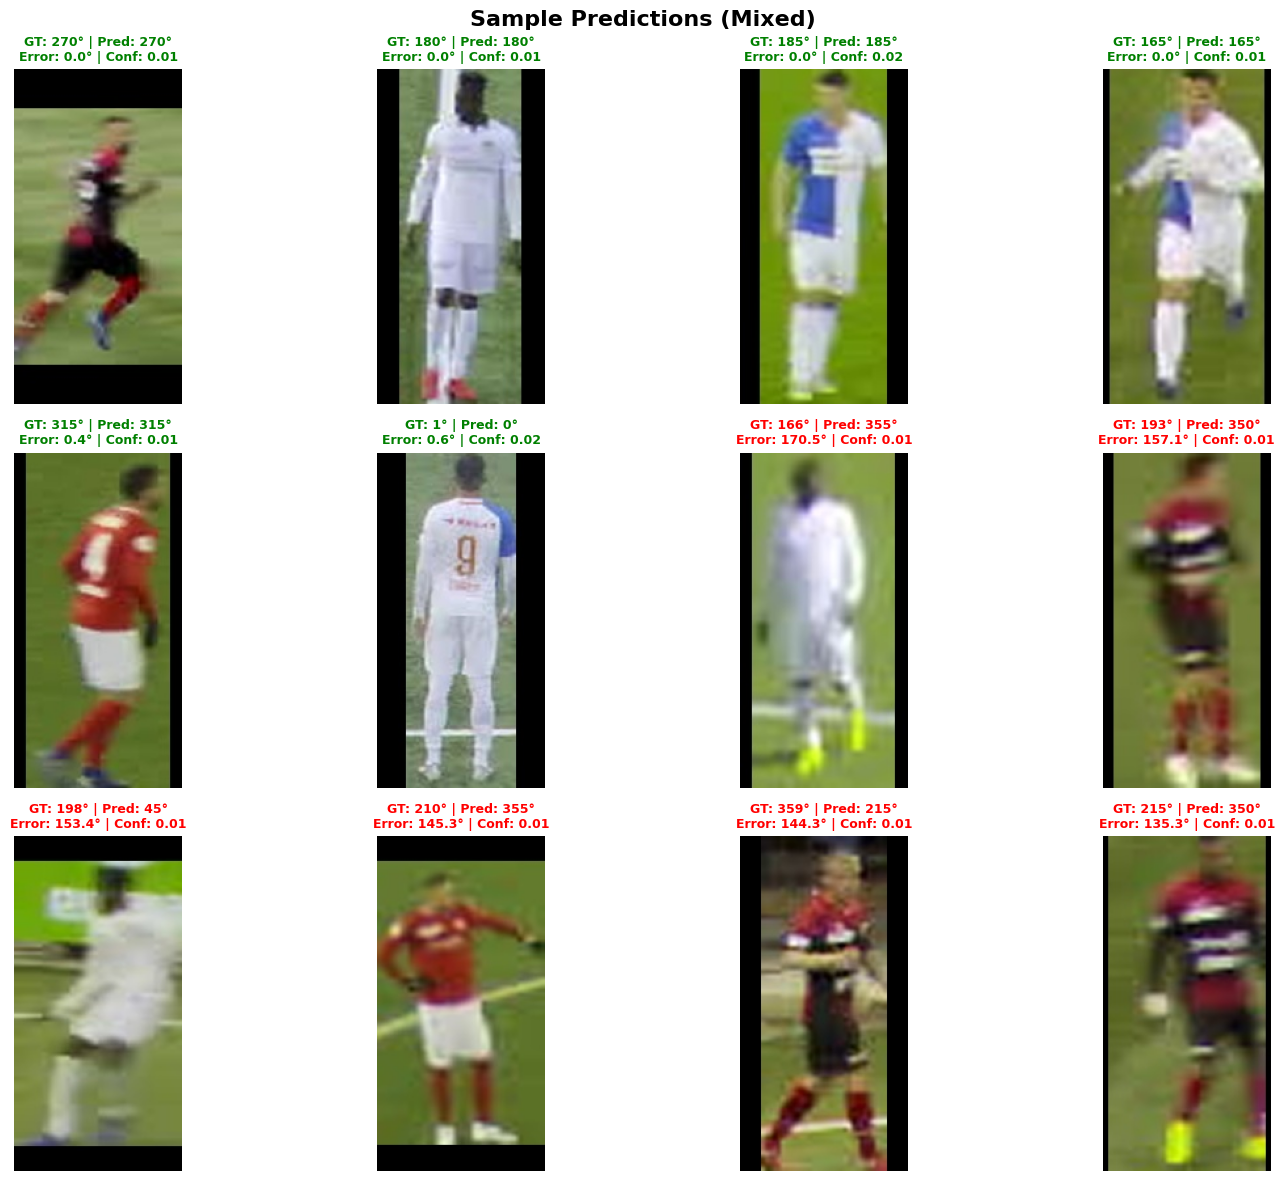


✓ Saved: sample_predictions_mixed.png


In [48]:
# Visualize sample predictions
def visualize_predictions(df, n_samples=12, selection='mixed'):
    """
    Visualize sample predictions
    selection: 'best', 'worst', 'mixed', 'random'
    """
    if selection == 'best':
        samples = df.nsmallest(n_samples, 'error')
    elif selection == 'worst':
        samples = df.nlargest(n_samples, 'error')
    elif selection == 'mixed':
        best = df.nsmallest(n_samples//2, 'error')
        worst = df.nlargest(n_samples//2, 'error')
        samples = pd.concat([best, worst])
    else:
        samples = df.sample(n_samples)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= n_samples:
            break

        img_path = Path(CONFIG['player_dataset']) / 'test' / 'images' / row['filename']
        img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Color based on error
        error = row['error']
        if error < 15:
            color = 'green'
        elif error < 30:
            color = 'orange'
        else:
            color = 'red'

        title = f"GT: {row['gt_angle']:.0f}° | Pred: {row['pred_angle']:.0f}°\nError: {error:.1f}° | Conf: {row['confidence']:.2f}"
        axes[idx].set_title(title, fontsize=9, color=color, fontweight='bold')

    plt.suptitle(f'Sample Predictions ({selection.title()})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / f'sample_predictions_{selection}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Show mixed examples
visualize_predictions(df, n_samples=12, selection='mixed')
print("\n✓ Saved: sample_predictions_mixed.png")

## 12. Save Results

In [49]:
# Save detailed results
output_csv = Path(CONFIG['output_dir']) / 'mebow_predictions.csv'
df.to_csv(output_csv, index=False)
print(f"✓ Saved detailed results: {output_csv}")

# Save summary statistics
summary = {
    'model': 'MEBOW (HRNet)',
    'dataset': 'Soccer Player Direction Test Set',
    'total_samples': len(df),
    'statistics': {
        'mae': float(df['error'].mean()),
        'median_error': float(df['error'].median()),
        'std_error': float(df['error'].std()),
        'min_error': float(df['error'].min()),
        'max_error': float(df['error'].max()),
    },
    'accuracy': {
        'within_5deg': float((df['error'] <= 5).mean() * 100),
        'within_15deg': float((df['error'] <= 15).mean() * 100),
        'within_30deg': float((df['error'] <= 30).mean() * 100),
        'within_45deg': float((df['error'] <= 45).mean() * 100),
        'within_90deg': float((df['error'] <= 90).mean() * 100),
    },
    'confidence': {
        'mean': float(df['confidence'].mean()),
        'median': float(df['confidence'].median()),
        'std': float(df['confidence'].std()),
    }
}

summary_file = Path(CONFIG['output_dir']) / 'mebow_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary: {summary_file}")

# Save failed samples
if failed_samples:
    failed_file = Path(CONFIG['output_dir']) / 'failed_samples.json'
    with open(failed_file, 'w') as f:
        json.dump(failed_samples, f, indent=2)
    print(f"✓ Saved failed samples: {failed_file}")

✓ Saved detailed results: /content/drive/MyDrive/mebow_test_results/mebow_predictions.csv
✓ Saved summary: /content/drive/MyDrive/mebow_test_results/mebow_summary.json


## 13. Conclusions

In [50]:
print("="*70)
print("CONCLUSIONS")
print("="*70)

mae = df['error'].mean()
acc_30 = (df['error'] <= 30).mean() * 100

print(f"\n1. MEBOW PERFORMANCE ON SOCCER PLAYERS:")
print(f"   MAE: {mae:.2f}°")
print(f"   Accuracy@30°: {acc_30:.1f}%")

if mae < 30:
    performance = "excellent"
elif mae < 45:
    performance = "good"
elif mae < 60:
    performance = "moderate"
else:
    performance = "poor"

print(f"   Overall: {performance.upper()}")

print(f"\n2. KEY OBSERVATIONS:")
print(f"   • MEBOW was trained on COCO (general human orientation)")
print(f"   • Our task: Soccer players with specific field orientation")
print(f"   • Domain gap: General humans vs sports-specific context")

print(f"\n3. POTENTIAL ISSUES:")
print(f"   • Coordinate system mismatch (MEBOW vs our field-based system)")
print(f"   • MEBOW trained on full-body images, may struggle with crops")
print(f"   • Soccer-specific poses and uniforms not well represented in COCO")

print(f"\n4. NEXT STEPS:")
if mae > 40:
    print(f"   ⚠ Consider fine-tuning MEBOW on soccer data")
    print(f"   ⚠ Verify coordinate system alignment")
    print(f"   ⚠ Our custom model may be better suited for this task")
else:
    print(f"   ✓ MEBOW shows promising generalization")
    print(f"   ✓ Could be used as baseline or for comparison")
    print(f"   → Fine-tuning could further improve performance")

print("\n" + "="*70)

CONCLUSIONS

1. MEBOW PERFORMANCE ON SOCCER PLAYERS:
   MAE: 35.90°
   Accuracy@30°: 45.9%
   Overall: GOOD

2. KEY OBSERVATIONS:
   • MEBOW was trained on COCO (general human orientation)
   • Our task: Soccer players with specific field orientation
   • Domain gap: General humans vs sports-specific context

3. POTENTIAL ISSUES:
   • Coordinate system mismatch (MEBOW vs our field-based system)
   • MEBOW trained on full-body images, may struggle with crops
   • Soccer-specific poses and uniforms not well represented in COCO

4. NEXT STEPS:
   ✓ MEBOW shows promising generalization
   ✓ Could be used as baseline or for comparison
   → Fine-tuning could further improve performance

